# Documentation

This note is aim to demo how insurance company model and evaluate claim severity.

The data used here are from [Actuarial loss prediction](https://www.kaggle.com/competitions/actuarial-loss-estimation/overview).

# Download file and environment

In [1]:
# !pip install kaggle
# !kaggle competitions download -c actuarial-loss-estimation
# 
# ! pip install pandas numpy matplotlib ydata-profiling scikit-learn xgboost

In [2]:
# # importing the zipfile module 
# from zipfile import ZipFile 
# # loading the temp.zip and creating a zip object 
# with ZipFile("actuarial-loss-estimation.zip", 'r') as zObject: 
# 	zObject.extractall(path="./data") 


# EDA

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [4]:
train_dev = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/train.csv")
# rename misspelled columns names
train_dev.rename(columns={'InitialIncurredCalimsCost': 'InitialIncurredClaimsCost'}, inplace=True)
test.rename(columns={'InitialIncurredCalimsCost': 'InitialIncurredClaimsCost'}, inplace=True)

print(train_dev.columns)

Index(['ClaimNumber', 'DateTimeOfAccident', 'DateReported', 'Age', 'Gender',
       'MaritalStatus', 'DependentChildren', 'DependentsOther', 'WeeklyWages',
       'PartTimeFullTime', 'HoursWorkedPerWeek', 'DaysWorkedPerWeek',
       'ClaimDescription', 'InitialIncurredClaimsCost',
       'UltimateIncurredClaimCost'],
      dtype='object')


In [5]:
from ydata_profiling import ProfileReport

profile = ProfileReport(train_dev, title="Profiling Loss Cost Report")
profile.to_file("./eda_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

count    54000.000000
mean       416.364807
std        248.638669
min          1.000000
10%        200.000000
20%        200.000000
30%        244.710000
40%        333.478000
50%        392.200000
60%        447.724000
70%        500.000000
80%        548.014000
90%        681.451000
95%        817.005500
99%       1237.520000
100%      7497.000000
max       7497.000000
Name: WeeklyWages, dtype: float64
0    200.0
Name: WeeklyWages, dtype: float64


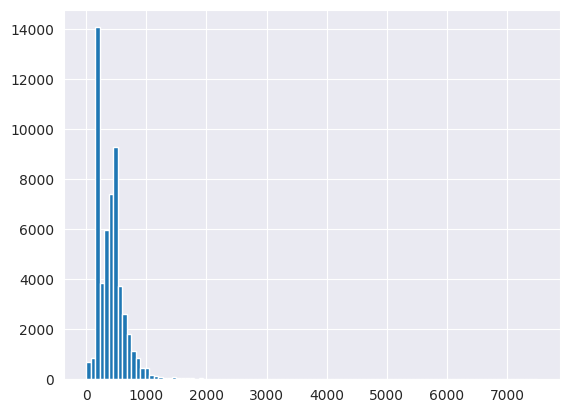

In [6]:
print(train_dev['WeeklyWages'].describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1.0]))
train_dev['WeeklyWages'].hist(bins=100)
print(train_dev['WeeklyWages'].mode())

count    54000.000000
mean        37.735084
std         12.568704
min          0.000000
10%         34.500000
20%         38.000000
30%         38.000000
40%         38.000000
50%         38.000000
60%         38.000000
70%         38.000000
80%         40.000000
90%         40.000000
95%         40.000000
99%         60.000000
100%       640.000000
max        640.000000
Name: HoursWorkedPerWeek, dtype: float64
0    38.0
Name: HoursWorkedPerWeek, dtype: float64


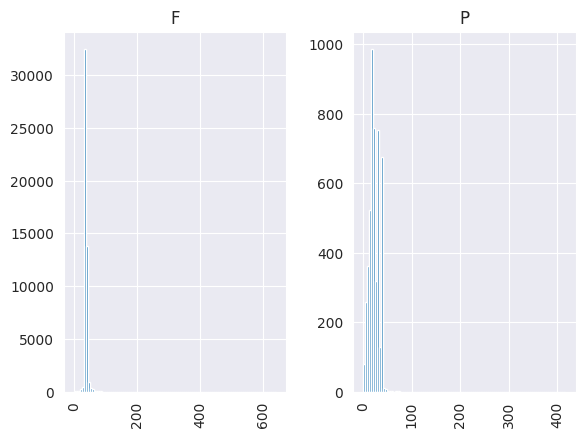

In [7]:
print(train_dev['HoursWorkedPerWeek'].describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1.0]))
train_dev['HoursWorkedPerWeek'].hist(by=train_dev['PartTimeFullTime'], bins=100)
print(train_dev['HoursWorkedPerWeek'].mode())

In [8]:
# Variable consistency
# HoursWorkedPerWeek is zero but wage may not
print(train_dev[train_dev['HoursWorkedPerWeek'] == 0][['WeeklyWages','PartTimeFullTime', 'HoursWorkedPerWeek', 'DaysWorkedPerWeek']].sample(10, random_state=42).reset_index(drop=True))
print(f"Percentage of HoursWorkedPerWeek is zero: {sum(train_dev['HoursWorkedPerWeek'] == 0) / len(train_dev['HoursWorkedPerWeek']): .3%}")

   WeeklyWages PartTimeFullTime  HoursWorkedPerWeek  DaysWorkedPerWeek
0       418.00                P                 0.0                  1
1       596.15                F                 0.0                  5
2       439.80                F                 0.0                  5
3         1.00                F                 0.0                  1
4        68.00                P                 0.0                  1
5       500.00                P                 0.0                  1
6       500.00                F                 0.0                  5
7       455.00                F                 0.0                  3
8       481.08                F                 0.0                  1
9       368.60                F                 0.0                  5
Percentage of HoursWorkedPerWeek is zero:  0.054%


count    5.400000e+04
mean     7.841146e+03
std      2.058408e+04
min      1.000000e+00
10%      5.000000e+02
20%      5.000000e+02
30%      9.500000e+02
40%      1.260000e+03
50%      2.000000e+03
60%      3.500000e+03
70%      7.500000e+03
80%      1.000000e+04
90%      1.850000e+04
95%      3.000000e+04
99%      7.500000e+04
100%     2.000000e+06
max      2.000000e+06
Name: InitialIncurredClaimsCost, dtype: float64


Text(0.5, 1.0, 'Log InitialIncurredClaimsCost')

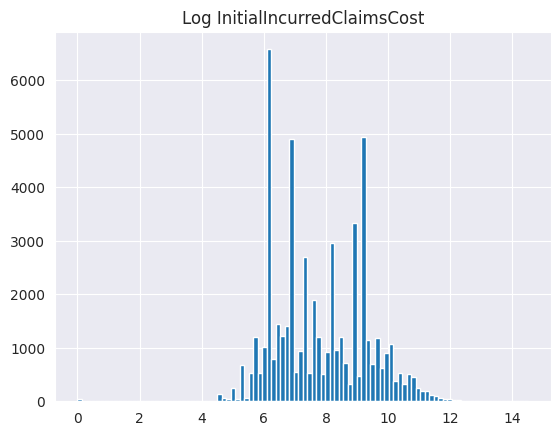

In [9]:
# InitialIncurredClaimsCost has long tail, thus apply log transformation
print(train_dev['InitialIncurredClaimsCost'].describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1.0]))
train_dev['InitialIncurredClaimsCost_log'] = np.log(train_dev['InitialIncurredClaimsCost'])
train_dev['InitialIncurredClaimsCost_log'].hist(bins=100)
plt.title('Log InitialIncurredClaimsCost')

count    5.400000e+04
mean     1.100337e+04
std      3.339099e+04
min      1.218868e+02
10%      4.238908e+02
20%      7.170157e+02
30%      1.209882e+03
40%      1.979777e+03
50%      3.371242e+03
60%      5.113480e+03
70%      6.915432e+03
80%      1.043851e+04
90%      2.400578e+04
95%      4.522418e+04
99%      1.390250e+05
100%     4.027136e+06
max      4.027136e+06
Name: UltimateIncurredClaimCost, dtype: float64


Text(0.5, 1.0, 'Log UltimateIncurredClaimCost')

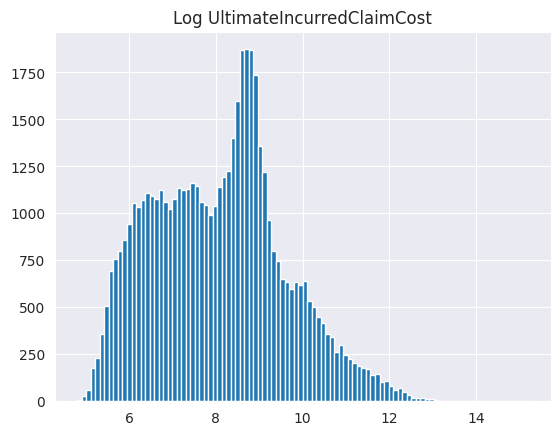

In [10]:
# Target, UltimateIncurredClaimCost, has long tail, thus apply log transformation.
print(train_dev['UltimateIncurredClaimCost'].describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1.0]))
train_dev['UltimateIncurredClaimCost_log'] = np.log(train_dev['UltimateIncurredClaimCost'])
train_dev['UltimateIncurredClaimCost_log'].hist(bins=100)
plt.title('Log UltimateIncurredClaimCost')

Summary of the features
- Features with tail need to be capped: 
    - Continue: HoursWorkedPerWeek, WeeklyWages, 
    - Numerical: DependentsOther, DependentChildren
    - Categorical: Gender
- Highly correlated features: 
    - DaysWorkedPerWeek, PartTimeFullTime
    - HoursWorkedPerWeek, DaysWorkedPerWeek
    - Age, MaritalStatus
    - PartTimeFullTime, Gender
- Date time: DateTimeOfAccident, DateReported
- NLP feature: ClaimDescription
- Targets: UltimateIncurredClaimCost
    - Feature highly correlated to targets: InitialIncurredClaimsCost, Age, DependentChildren, WeeklyWages

## Feature Engineer

In [11]:
columns_input = train_dev.columns.to_list()
columns_input

['ClaimNumber',
 'DateTimeOfAccident',
 'DateReported',
 'Age',
 'Gender',
 'MaritalStatus',
 'DependentChildren',
 'DependentsOther',
 'WeeklyWages',
 'PartTimeFullTime',
 'HoursWorkedPerWeek',
 'DaysWorkedPerWeek',
 'ClaimDescription',
 'InitialIncurredClaimsCost',
 'UltimateIncurredClaimCost',
 'InitialIncurredClaimsCost_log',
 'UltimateIncurredClaimCost_log']

In [12]:
# handel missing data by dropping them. This may lead to bias.
# train_dev = train_dev[train_dev['Gender'] != 'U']

count    54000.000000
mean        38.322759
std         61.111756
min         -1.000000
10%          8.000000
20%         11.000000
30%         14.000000
40%         17.000000
50%         21.000000
60%         27.000000
70%         35.000000
80%         48.000000
90%         77.000000
95%        121.000000
99%        295.000000
100%      1094.000000
max       1094.000000
Name: ReportLag, dtype: float64


<Axes: >

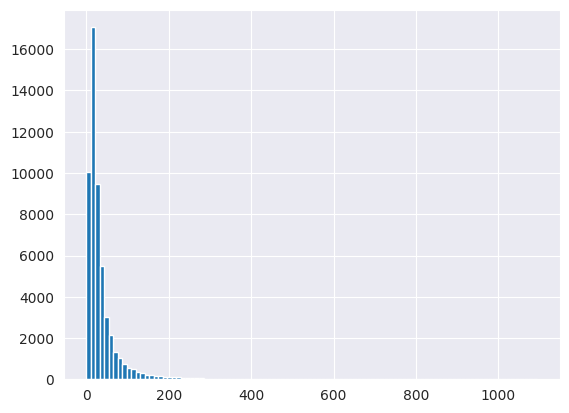

In [13]:
# Date time features
train_dev["DateTimeOfAccident"] = pd.to_datetime(train_dev["DateTimeOfAccident"])
train_dev["DateReported"] = pd.to_datetime(train_dev["DateReported"])
train_dev["ReportLag"] = (train_dev["DateReported"] - train_dev["DateTimeOfAccident"]).dt.days
print(train_dev["ReportLag"].describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1.0]))

train_dev.loc[:, 'ReportLag'] = train_dev['ReportLag'].clip(lower=0)
train_dev["ReportLag"].hist(bins=100)

In [14]:
columns_categorical = [
 'Gender',
 'MaritalStatus',
 'PartTimeFullTime',
]

columns_numerical = [
 'Age',
 'DependentChildren',
 'DependentsOther',
 'WeeklyWages',
 'HoursWorkedPerWeek',
 'DaysWorkedPerWeek',
 'InitialIncurredClaimsCost_log', # 'InitialIncurredClaimsCost',
 'ReportLag'
]
columns_text = ['ClaimDescription']
columns_target = ['UltimateIncurredClaimCost']

train_dev[columns_categorical] = train_dev[columns_categorical].astype("category")

categorical_columns = train_dev.select_dtypes(include="category").columns
n_categorical_features = len(categorical_columns)
n_numerical_features = train_dev.select_dtypes(include="number").shape[1]

print(f"Number of samples: {train_dev.shape[0]}")
print(f"Number of features: {train_dev.shape[1]}")
print(f"Number of categorical features: {n_categorical_features}")
print(f"Number of numerical features: {n_numerical_features}")

Number of samples: 54000
Number of features: 18
Number of categorical features: 3
Number of numerical features: 11


In [15]:
# Cap features that have long tail
train_dev['DependentChildren'] = train_dev['DependentChildren'].clip(upper=3)
train_dev['DependentsOther'] = train_dev['DependentsOther'].clip(upper=1)
train_dev['HoursWorkedPerWeek'] = train_dev['HoursWorkedPerWeek'].clip(upper=100)


count    54000.000000
mean         5.866460
std          0.655902
min          0.000000
10%          5.298317
20%          5.298317
30%          5.500074
40%          5.809577
50%          5.971772
60%          6.104177
70%          6.214608
80%          6.306301
90%          6.524224
95%          6.705646
99%          7.120865
100%         8.922258
max          8.922258
Name: WeeklyWages_log, dtype: float64
0    5.298317
Name: WeeklyWages_log, dtype: float64


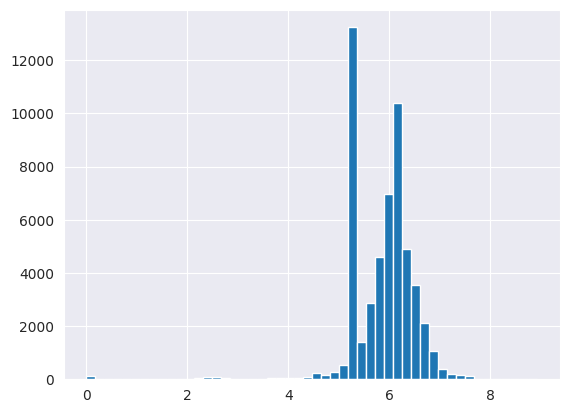

In [16]:
# Skew feature log transfer
train_dev['WeeklyWages_log'] = np.log(train_dev['WeeklyWages'])

print(train_dev['WeeklyWages_log'].describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1.0]))
train_dev['WeeklyWages_log'].hist(bins=50)
print(train_dev['WeeklyWages_log'].mode())


In [17]:
full_scaler = StandardScaler(with_std=False).fit(train_dev[columns_numerical])
# control_scaler = StandardScaler(with_std=False).fit(X_train)

# Modeling

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
# drop NA, infinity values
train_dev.replace(-np.inf, np.nan)
train_dev.replace(np.inf, np.nan)
train_dev.replace([np.inf, -np.inf], np.nan).dropna(axis=1, inplace=True)

In [20]:
columns_X = columns_numerical # columns_categorical + columns_numerical, 
X = train_dev[columns_X]
# X = pd.get_dummies(data=train_dev[columns_categorical + columns_numerical], columns=columns_categorical, drop_first=True).values

y = train_dev['UltimateIncurredClaimCost_log']

X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.2, random_state=12)

In [21]:
# import xgboost as xgb
# 
# # create a xgboost regression model
# model = xgb.XGBRegressor(enable_categorical=True, objective='reg:gamma', n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8, early_stopping_rounds=10)
# # Fit the model, test sets are used for early stopping.
# model.fit(X_train, y_train, eval_set=[(X_dev, y_dev)])
# # Save model into JSON format.
# # model.save_model("./model/xgboost.json")

In [22]:
# fit a linear regression model
import statsmodels.api as sm 

y_train_log = np.log(y_train)
y_dev_log = np.log(y_dev)

X_train_1 = sm.add_constant(X_train)
X_dev_1 = sm.add_constant(X_dev)
model = sm.OLS(y_train_log, X_train_1).fit()
print(model.summary())

# make a prediction
yhat_train_log = model.predict(X_train_1)
yhat_dev_log = model.predict(X_dev_1)

                                  OLS Regression Results                                 
Dep. Variable:     UltimateIncurredClaimCost_log   R-squared:                       0.742
Model:                                       OLS   Adj. R-squared:                  0.742
Method:                            Least Squares   F-statistic:                 1.555e+04
Date:                           Tue, 13 Aug 2024   Prob (F-statistic):               0.00
Time:                                   10:45:13   Log-Likelihood:                 39572.
No. Observations:                          43200   AIC:                        -7.913e+04
Df Residuals:                              43191   BIC:                        -7.905e+04
Df Model:                                      8                                         
Covariance Type:                       nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
--

# Evaluation

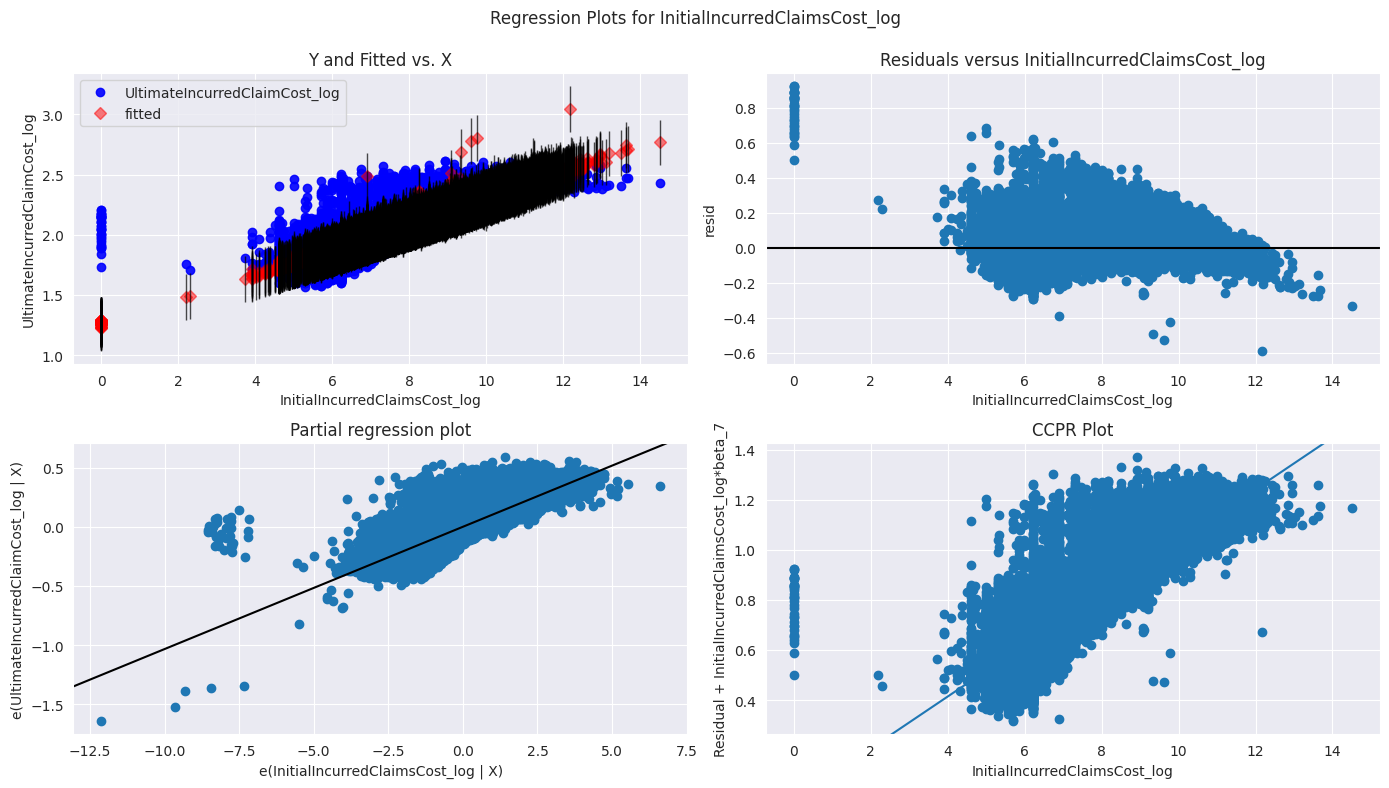

In [23]:
# creating regression plots 
fig = plt.figure(figsize=(14, 8)) 
fig = sm.graphics.plot_regress_exog(model, 'InitialIncurredClaimsCost_log', fig=fig) 

In [24]:
# Evaluate matrices
from sklearn import metrics 
r2_score = metrics.r2_score(y_dev_log, yhat_dev_log)
mean_squared_error = metrics.mean_squared_error(y_dev_log, yhat_dev_log)

print(f"Mean squared error: {mean_squared_error: 0.5f}")
print(f"R2 score: {r2_score: 0.5f}")

Mean squared error:  0.00978
R2 score:  0.73366


## R-Square

`R-Square = explained sum of squares / total sum of squares = (total sum of squares - residual sum of squares) / total sum of squares`

Assumptions
- Linear regression. Relationship between dependent and independent variables are linear. `total sum of squares = explained sum of squares + residual sum of squares` 
- When number of observation approaches infinity, the R Square should approach zero. 

Concerns with calculate R-Square on quantile data
- Which mean should it be use in the quantile?
    - Use the quantile mean and only the records in the quantile: This is same as r-square in the subset. But the regression is not fitted to this data, thus it is not informative for the regression model performance. For example, the subgroup with `InitialIncurredClaimsCost_log` value equal to zero, would have a much higher R square, since it is tightly group together. The total sum of squares used in subgroups is different from the total sum of squares of whole dataset. Thus, `total sum of squares = explained sum of squares + residual sum of squares` no longer hold.
    - Use the whole dataset mean and whole dataset as the denominator, but only include quantile data in numerator: The advantage of this approach is that sum of the R Square of each subgroup is the R Square of whole dataset. This does show how well each bucket fit. But the percentage cannot be view as the percentage of variance explained by the regression.

## Box Plot
Box plot by quantile shows understand the distribution of residual by showing the Interquartile Range and outliers for each segments of the data.

## Lift Chart

Lift chart show the goodness-of-fit for each subgroup. It evaluates how well model perform on difference segments of the data. Especially, is the model doing well in both low risk and high risk subgroup?
Creating a quantile plot
- Use holdout sample.
- Sort data based on predicted value (frequency, severity, loss cost).
- Subdivide sorted data into quantiles (quartiles, quantiles, deciles) with equal weight (exposure, claim count).
- Calculate average actual value and predicted value for each quantile and index to overall average.

Checking a quantile plot
- Is there a close match between actual and predicted values?
- Are values increasing monotonically or with few reversals?
- How well does the model distinguish between low cost and high risk?

Reference
- [R Square wiki page](https://en.wikipedia.org/wiki/Coefficient_of_determination)
- [R² score documentation on sklearn](https://scikit-learn.org/stable/modules/model_evaluation.html#r2-score)
- [How to define R squared on a subset of the original sample?](https://stats.stackexchange.com/questions/324773/how-to-define-r-squared-on-a-subset-of-the-original-sample)
- [And The Winner Is…? How to Pick a Better Model, CAS](https://www.casact.org/sites/default/files/presentation/rpm_2016_presentations_pm-lm-4.pdf)


In [25]:
import seaborn as sns 

from utils import LiftChart

double check the math:  [0.15517165 0.27699453 0.32953881 0.3608721  0.36211649 0.3681676
 0.38889062 0.43035752 0.52316089 0.73371368]
   bin  exposure  r_square  cumulative_r_square
0  0.0  0.099907  0.155172             0.940166
1  1.0  0.100000  0.121823             0.897098
2  2.0  0.100093  0.052544             0.866119
3  3.0  0.099907  0.031333             0.836971
4  4.0  0.100093  0.001244             0.811929
5  5.0  0.100000  0.006051             0.785524
6  6.0  0.100000  0.020723             0.770560
7  7.0  0.099907  0.041467             0.757713
8  8.0  0.100093  0.092803             0.745544
9  9.0  0.100000  0.210553             0.733714


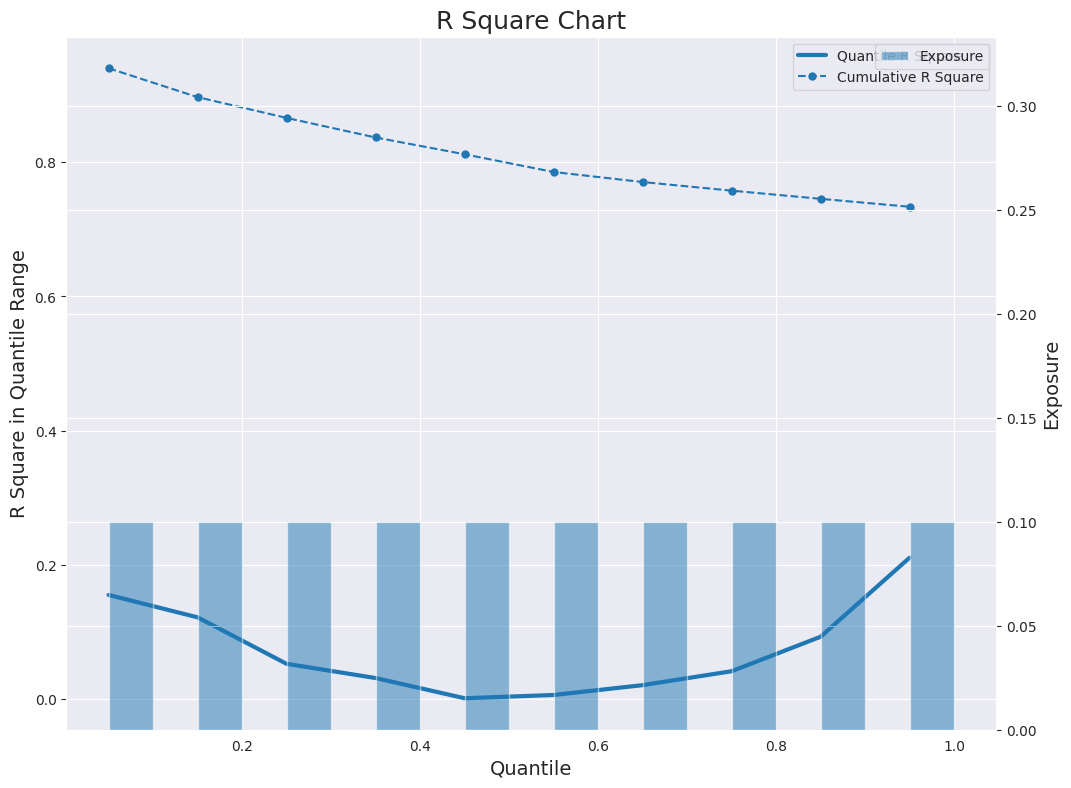

In [26]:
# Quantile and Cumulative R Square 
lift = LiftChart(y_dev_log, yhat_dev_log)
data_r_square = lift.quantile_data_r_square(n_quantiles=10)
print("double check the math: ", np.cumsum(data_r_square["r_square"]))

ax = lift.quantile_plot(n_quantiles=10, chart="r_square")
print(pd.DataFrame(data_r_square))

<Axes: xlabel='bin', ylabel='residual'>

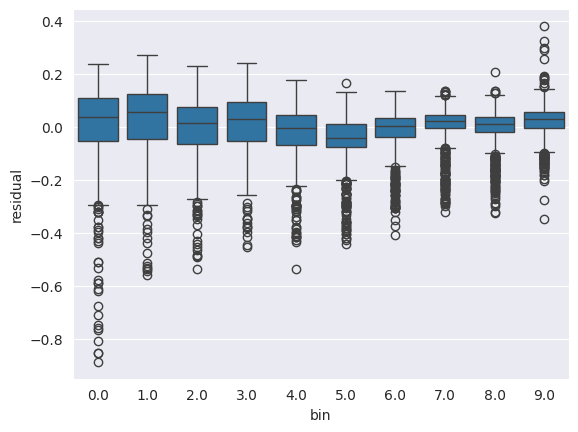

In [27]:
# create grouped boxplot  
sns.boxplot(x = lift.data['bin'], 
            y = lift.data['residual'])

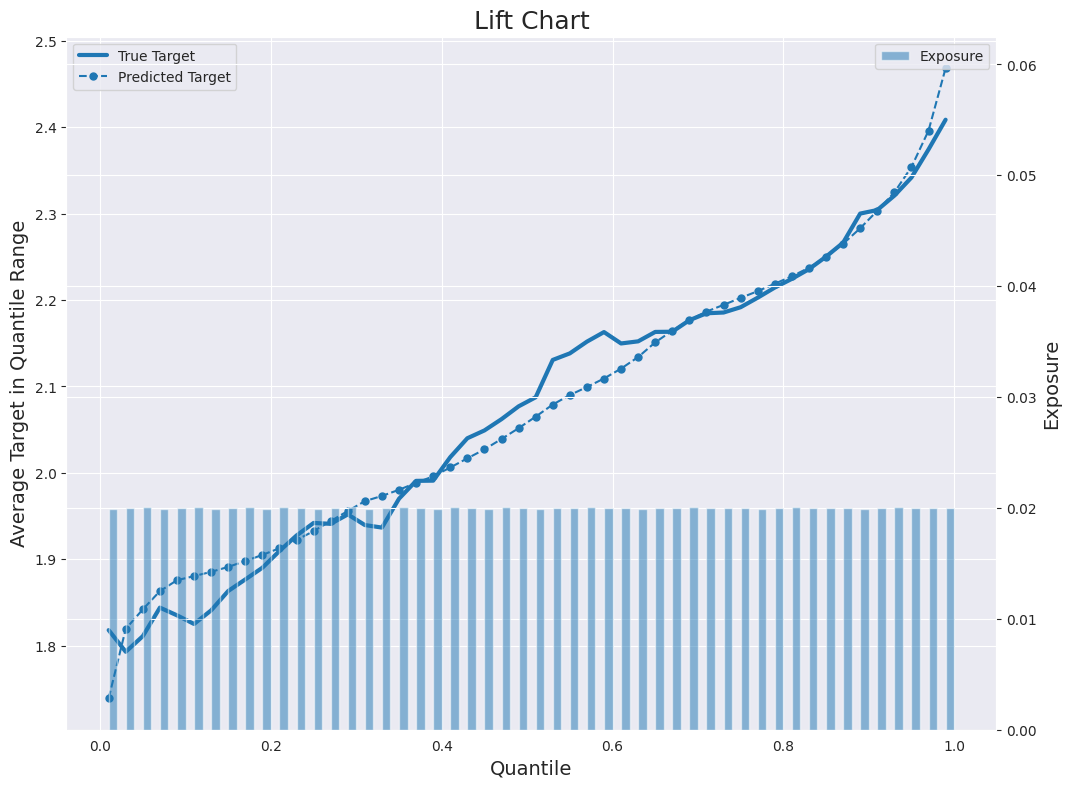

In [28]:
# Lift Chart
lift = LiftChart(y_dev_log, yhat_dev_log)
ax = lift.quantile_plot(n_quantiles=50, chart="lift")